In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
#working with images
import cv2
from PIL import Image,ImageOps,ImageEnhance
from io import BytesIO

#others
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os 
import random
import random

#API
import requests

import tensorflow as tf
#import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks

from sklearn.pipeline import make_pipeline

from pokedex.augmentation import get_augment_data,transform_array,apply_blur

import pytesseract
import pyocr
from transformers import TFVisionEncoderDecoderModel,TrOCRProcessor,TrOCRForCausalLM,VisionEncoderDecoderModel

In [10]:
def local_generate_augmented_image(image_np):
    """
    Generate augmented image
    """
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=7,
        width_shift_range=3,
        height_shift_range=2,
        preprocessing_function=apply_blur
    )

    it = datagen.flow(image_np, batch_size=1)
    augmented_image = next(it)[0].astype(np.uint8)
    return augmented_image

# OCR TESTING

## Downloading the augmented data

In [11]:
path_name_left = '/Users/emiliasato/code/AoesJP/project_pokereader/raw_data/dict_reduceddataset_left.json'
path_name_right = '/Users/emiliasato/code/AoesJP/project_pokereader/raw_data/dict_reduceddataset_right.json'
augmented_df_left = get_augment_data(path_name_left)
augmented_df_right = get_augment_data(path_name_right)

## Creating CV and PIL objects

Average pixel intensity: 209.32743827160493
Proportion of white pixels: 0.8077777777777778
Primarily white


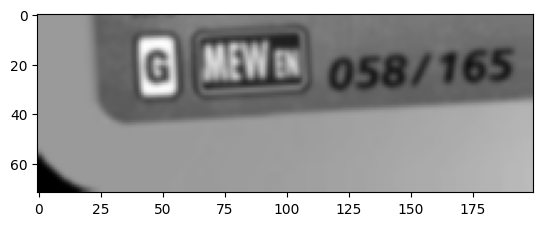

In [159]:
im_np = augmented_df_left.loc[2003,'corner']
plt.imshow(im_np)
im_pil = Image.fromarray(np.squeeze(im_np))
#im_pil = ImageOps.invert(im_pil)
im_cv = cv2.cvtColor(im_np, cv2.COLOR_RGB2BGR)
#im_cv = cv2.cvtColor(im_cv, cv2.COLOR_BGR2GRAY)
deformed_cv = deforming(im_cv)
print(is_primarily_white(deformed_cv))
im_pil
plt.imshow(im_cv,cmap='gray')


In [163]:
augmented_df_left.loc[101,'corner'].shape

(1, 72, 200, 1)

In [162]:
augmented_df_left.loc[2003,'corner'].shape

(72, 200, 1)

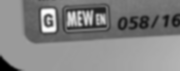

In [158]:
width, height = im_pil.size
bottom_left_coords = (0, height*0.01, width*0.9, height)
bottom_left = im_pil.crop(bottom_left_coords)
bottom_left

Average pixel intensity: 204.9033024691358
Proportion of white pixels: 0.7940432098765432
Primarily white


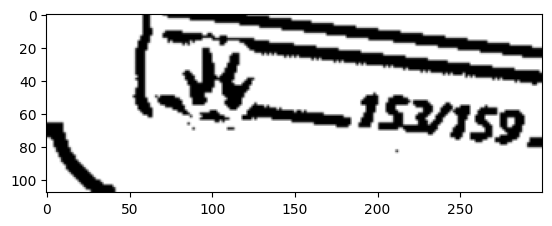

In [100]:
def is_primarily_white(image_np, threshold=128):
    # Open the image and convert it to grayscale
    #image = Image.open(image_path).convert("L")
    
    # Convert the image to a numpy array
    #image_np = np.array(image)
    
    # Calculate the average pixel intensity
    average_intensity = np.mean(image_np)
    
    # Calculate the proportion of white pixels (above threshold)
    white_pixels_ratio = np.mean(image_np > threshold)
    
    # Print the results
    print(f"Average pixel intensity: {average_intensity}")
    print(f"Proportion of white pixels: {white_pixels_ratio}")
    
    # Determine if the image is primarily white
    if white_pixels_ratio > 0.5:
        return "Primarily white"
    else:
        return "Primarily black"

deformed_cv = deforming(im_cv)
print(is_primarily_white(deformed_cv))
plt.imshow(deformed_cv,cmap='gray')

In [30]:
pixel_values = processor(images=im_cv, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

'@ 087/165'

# Tessearct OCR

In [142]:
def image_to_text(img: Image.Image,psm):
    # TesseractでOCRを実行
    config = f"--oem 3 --psm {psm} -c tessedit_char_whitelist=0123456789/"
    text = pytesseract.image_to_string(img,lang='eng',config=config)

    return text

for psm in [1,3,4,5,6,7,8,9,10,12,13]:
    text = image_to_text(deformed_cv,psm)
    print(psm,text)

1 165

3 165

4 165

5 
6 
7 
8 
9 
10 
12 16

13 


## pyocr (takes in opencv object)

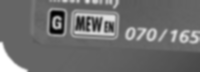

In [585]:
im_pil

In [607]:
deforming(im_cv)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

''

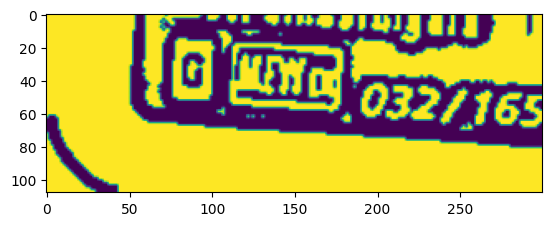

In [74]:
def deforming(im_cv):
    gray = cv2.cvtColor(im_cv, cv2.COLOR_BGR2GRAY)

    # Denoise
    img_denoised = cv2.fastNlMeansDenoising(gray, None, h=9, templateWindowSize=7, searchWindowSize=21)
    
    # Apply adaptive thresholding
    img_thresh = cv2.adaptiveThreshold(img_denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
    
    # Sharpen
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    img_sharpened = cv2.filter2D(img_thresh, -1, kernel)
    
    # Rescale
    scale_percent = 150
    width = int(img_sharpened.shape[1] * scale_percent / 100)
    height = int(img_sharpened.shape[0] * scale_percent / 100)
    dim = (width, height)
    img_rescaled = cv2.resize(img_sharpened, dim, interpolation=cv2.INTER_LINEAR)
    return img_rescaled

plt.imshow(im_cv)
plt.imshow(deforming(im_cv))
deformed_cv = deforming(im_cv)
image_to_text(deformed_cv,6)

In [574]:
## currently testing
img_sharpened_pil = Image.fromarray(img_sharpened)
tools = pyocr.get_available_tools()
tool = tools[0]
tool
builder = pyocr.builders.TextBuilder(tesseract_layout=6)
# builder.tesseract_configs.append("digits")
builder.tesseract_configs.append("-c")
builder.tesseract_configs.append("tessedit_char_whitelist=0123456789/")
builder.tesseract_configs.append("--psm")
builder.tesseract_configs.append("7")  # 0~13
builder.tesseract_configs.append("--oem")
builder.tesseract_configs.append("0")  # 0~3
res = tool.image_to_string(img_sharpened_pil, lang="eng", builder=builder)

print(res)

TesseractError: (1, b"Error: Tesseract (legacy) engine requested, but components are not present in /usr/local/share/tessdata/eng.traineddata!!\nFailed loading language 'eng'\nTesseract couldn't load any languages!\nCould not initialize tesseract.\n")

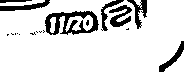

In [214]:
pil_sharpened = Image.fromarray(img_sharpened)
pil_sharpened

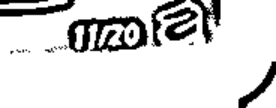

In [215]:
pil_rescaled = Image.fromarray(img_rescaled)
pil_rescaled

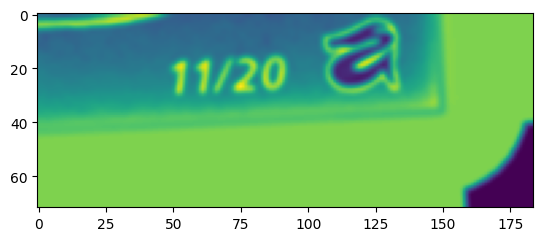

In [198]:
plt.imshow(im)

## using pyOCR

In [575]:
success1 = pil_rescaled

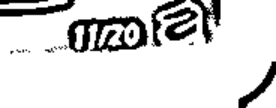

In [576]:
success1

In [577]:
## SUCCESSFUL FOR success1 - 11/20 snake symbol
tools = pyocr.get_available_tools()
tool = tools[0]
tool
builder = pyocr.builders.TextBuilder(tesseract_layout=6)
# builder.tesseract_configs.append("digits")
builder.tesseract_configs.append("-c")
builder.tesseract_configs.append("tessedit_char_whitelist=0123456789/")
builder.tesseract_configs.append("--psm")
builder.tesseract_configs.append("9")  # 0~13
builder.tesseract_configs.append("--oem")
builder.tesseract_configs.append("3")  # 0~3
res = tool.image_to_string(success1, lang="eng", builder=builder)

print(res)

11/20


# Successful Examples

### Using tesseract

In [135]:
def image_to_text(img: Image.Image):
    # TesseractでOCRを実行
    config = "--oem 3 --psm 1 -c tessedit_char_whitelist=0123456789/"
    text = pytesseract.image_to_string(img,lang='eng',config=config)

    return text

5 116/168



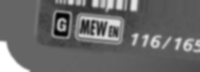

In [150]:
good_np1 = augmented_df_left.loc[2008,'corner']
good_pil1 = Image.fromarray(np.squeeze(good_np1))
good_pil1 = ImageOps.invert(good_pil1)
good_cv1 = cv2.cvtColor(good_np1, cv2.COLOR_RGB2BGR)
print(image_to_text(good_pil1,6))
good_pil1

In [132]:
good_deformed1 = deforming(good_cv1)
image_to_text(good_deformed1)

'116/16\n'

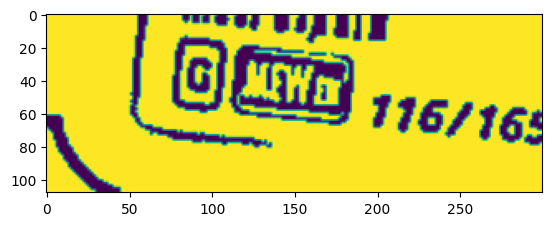

In [133]:
plt.imshow(good_deformed1)

087/165



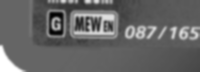

In [138]:
good_np2 = augmented_df_left.loc[2010,'corner']
good_pil2 = Image.fromarray(np.squeeze(good_np2))
good_pil2 = ImageOps.invert(good_pil2)
print(image_to_text(good_pil2))
good_pil2

In [122]:
def image_to_text(img: Image.Image):
    # TesseractでOCRを実行
    config = "--oem 3 --psm 1 -c tessedit_char_whitelist=0123456789/"
    text = pytesseract.image_to_string(img,lang='eng',config=config)

    return text
image_to_text(good_pil1)

NameError: name 'good_pil1' is not defined

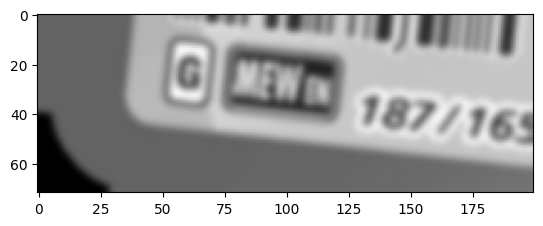

In [23]:
plt.imshow(im_cv)

In [21]:
plt.imshow(im_cv)
pixel_values = processor(images=im_cv, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

'DATE: 10/7/76'

## Using TROCRP

In [6]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed",use_fast=False)

In [7]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-printed")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def ocr_printed_image(img):
  pixel_values = processor(images=img, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values)
  return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [17]:
ocr_printed_image(im_pil)

ValueError: Unsupported number of image dimensions: 2

In [32]:
def preproc_clean(data: list):
    _ = np.array(data)
    return np.expand_dims(_, axis=2).astype("uint8")

def preproc_aug(data: list):
    _ = np.array(data)
    return np.squeeze(_.astype("uint8"), axis=0)

def to_rgb(img: np.ndarray):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

CPU times: user 1.08 s, sys: 87.9 ms, total: 1.17 s
Wall time: 534 ms


'1'

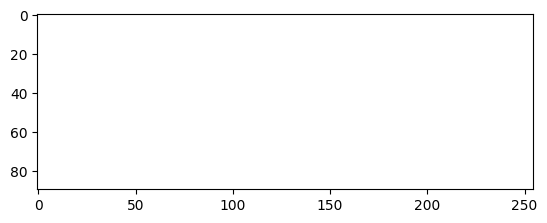

In [38]:
%%time
img = im_cv
# img = cv2.cvtColor(cv2.imread(IMG_PATH.as_posix()), cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# img = to_rgb(preproc_clean(df_all.iloc[643, 0]))
# img = to_rgb(preproc_clean(df_all.iloc[30, 0]))
# img = to_rgb(preproc_clean(df_all.iloc[20, 0]))
img = to_rgb(preproc_clean(augmented_df_left.iloc[10, 0]))
img = Image.fromarray(img)
# side_offset = 70
side_offset = 0
img = img.crop((45 + side_offset, 10, 130 + side_offset, 40))
img_contrast = img.resize((img.width * 3, img.height * 3), Image.BICUBIC)
contrast_enhancer = ImageEnhance.Contrast(img_contrast)
img_contrast = contrast_enhancer.enhance(1)
median = np.median(img_contrast)
# median = 30
mean = np.mean(img_contrast)
# mode = np.mode(img_contrast)
# im_offset = np.clip((img_contrast - np.array([median], dtype="int32")) * 2, 0, 255).astype("uint8")
im_offset = np.clip(img_contrast, 0, 255).astype("uint8")
im_offset = Image.fromarray(im_offset)
# plt.imshow(im_offset, vmin=0, vmax=255)
im_offset = ImageOps.invert(im_offset)
# im_offset = im_offset.rotate(-6, resample=Image.BICUBIC)
plt.imshow(im_offset)

pixel_values = processor(images=im_offset, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

In [19]:
pixel_values = processor(images=im_cv, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

/Users/emiliasato/.pyenv/versions/3.10.6/envs/project_pokereader/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'DATE: 10/7/76'